In [2]:
import numpy as np
from numpy import linalg
import math

In [3]:
np.set_printoptions(precision=3, suppress=True)

In [1]:
def matrix(img, orig):
    first = np.array(np.concatenate((np.array([0,0,0,0]), -img[2] * orig, img[1] * orig)))
    second = np.array(np.concatenate((img[2] * orig, np.array([0,0,0,0]), -img[0] * orig)))
    return np.array([first, second])

def matricaKamere(pts2D, pts3D):
    n = len(pts3D)
    A = np.zeros((2*n, 12))
    for i in range(n):
        org = pts3D[i]
        img = pts2D[i]
        A[2*i:2*i+2] = matrix(img, org)

    _, _, Vh = np.linalg.svd(A)
    T = Vh[-1].reshape(3,4)
    T = T/T[-1,-1]
    T = np.where(np.isclose(T, 0) , 0.0 , T)
    return T

In [2]:
def K(T):
    T0 = np.delete(T, 3, 1)
    if np.linalg.det(T0) < 0:
        T = (-1) * T
        T0 = np.delete(T, 3, 1)

    T0_inv = np.linalg.inv(T0)
    Q, R = np.linalg.qr(T0_inv)
    if (R[0,0] < 0):
        R = np.matmul(np.diag([-1, 1, 1]), R)
        Q = np.matmul(Q, np.diag([-1, 1, 1]))
    if (R[1,1] < 0):
        R = np.matmul(np.diag([1, -1, 1]), R)
        Q = np.matmul(Q, np.diag([1, -1, 1]))
    if (R[2,2] < 0):
        R = np.matmul(np.diag([1, 1, -1]), R)
        Q = np.matmul(Q, np.diag([1, 1, -1]))

    K = np.linalg.inv(R)
    K = K/K[-1,-1]
    K = np.where(np.isclose(K, 0) , 0.0 , K)
    return K

def C(T):
    C1 = np.linalg.det(np.delete(T, 0, 1))
    C2 = np.linalg.det(np.delete(T, 1, 1))
    C3 = np.linalg.det(np.delete(T, 2, 1))
    C4 = np.linalg.det(np.delete(T, 3, 1))
    center = np.array([C1, -C2, C3, -C4])
    center = (-1/C4) * center
    center = np.where(np.isclose(center, 0) , 0.0 , center)
    return center

def A(T):
    T0 = np.delete(T, 3, 1)
    if np.linalg.det(T0) < 0:
        T = (-1) * T
        T0 = np.delete(T, 3, 1)

    T0_inv = np.linalg.inv(T0)
    Q, R = np.linalg.qr(T0_inv)
    if (R[0,0] < 0):
        R = np.matmul(np.diag([-1, 1, 1]), R)
        Q = np.matmul(Q, np.diag([-1, 1, 1]))
    if (R[1,1] < 0):
        R = np.matmul(np.diag([1, -1, 1]), R)
        Q = np.matmul(Q, np.diag([1, -1, 1]))
    if (R[2,2] < 0):
        R = np.matmul(np.diag([1, 1, -1]), R)
        Q = np.matmul(Q, np.diag([1, 1, -1]))
    A = Q
    A = np.where(np.isclose(A, 0) , 0.0 , A)
    return A

In [39]:
img = np.array([1, -1, -1]) * (np.array([2000, 0, 0]) - np.array([[646, 696, 1],[854, 792, 1], [710, 942, 1], [478, 826, 1], [493, 1009, 1], [693, 1127, 1], [834, 987, 1], [682, 853, 1]]))

orgs = np.array([[0, 0, 3.3, 1], [0, 3.3, 3.3, 1], [3.3, 3.3, 3.3, 1], [3.3, 0, 3.3, 1], [3.3, 0, 0, 1], [3.3, 3.3, 0, 1], [0, 3.3, 0, 1], [0, 0, 0, 1]])

T = matricaKamere(img, orgs)
print("Matrica kamere: \n", T)
print("\n")
print("Matrica kalibracije kamere:\n", K(T))
print("\n")
print("Pozicija centra kamere:\n", C(T))
print("\n")
print("Spoljasna matrica kamere:\n", A(T))

Matrica kamere: 
 [[  -8.039  -67.23   -31.772 1336.591]
 [   3.654   20.559  -70.139  866.704]
 [  -0.038   -0.011   -0.025    1.   ]]


Matrica kalibracije kamere:
 [[1344.394 -104.92   842.765]
 [   0.    1428.765  616.05 ]
 [   0.       0.       1.   ]]


Pozicija centra kamere:
 [12.441 10.757 16.158  1.   ]


Spoljasna matrica kamere:
 [[-0.415 -0.406  0.814]
 [ 0.879 -0.411  0.243]
 [ 0.236  0.817  0.527]]


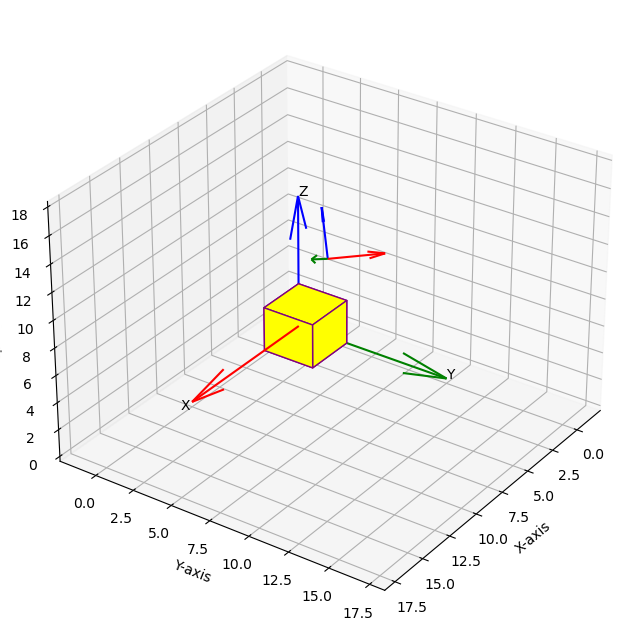

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def afine(hom_vector):
    afine_coords = hom_vector[:-1] / hom_vector[-1]
    return afine_coords

vertices = np.zeros((8, 3))
for i in range(8):
    vertices[i] = afine(orgs[i])

faces = [
    (7, 4, 5, 6),
    (0, 3, 2, 1),
    (7, 4, 3, 0),
    (5, 6, 1, 2),
    (4, 5, 2, 3),
    (7, 6, 1, 0)
]
def create_faces(vertices):
     return [[vertices[i], vertices[j], vertices[k], vertices[l]] for i, j, k, l in faces]

faces = create_faces(vertices)

origin = np.array([0, 0, 0])
axes = np.eye(3)

origin_kamera = afine(C(T))
axes_kamera = A(T).T

fig = plt.figure(figsize=(8, 8))
splot = fig.add_subplot(projection='3d')
splot.add_collection3d(Poly3DCollection(faces, facecolors='yellow', linewidths=1, edgecolors='purple'))

splot.quiver(*origin, *axes[0], color='r', length=10)
splot.text(origin[0] + axes[0][0] * 11, origin[1] + axes[0][1] * 10, origin[2] + axes[0][2] * 10, 'X', color='black')
splot.quiver(*origin, *axes[1], color='g', length=10)
splot.text(origin[0] + axes[1][0] * 11, origin[1] + axes[1][1] * 10, origin[2] + axes[1][2] * 10, 'Y', color='black')
splot.quiver(*origin, *axes[2], color='b', length=10)
splot.text(origin[0] + axes[2][0] * 11, origin[1] + axes[2][1] * 10, origin[2] + axes[2][2] * 10, 'Z', color='black')

splot.quiver(*origin_kamera, *axes_kamera[0], color='r', length=3)
splot.quiver(*origin_kamera, *axes_kamera[1], color='b', length=3)
splot.quiver(*origin_kamera, *axes_kamera[2], color='g', length=3)

splot.set_xlim(-2, 18)
splot.set_xlabel('X-axis')
splot.set_ylim(-2, 18)
splot.set_ylabel('Y-axis')
splot.set_zlim(0, 18)
splot.set_zlabel('Z-axis')

splot.view_init(elev=30, azim=35)
plt.show()